# Import Dataset

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os, sys, email, re



try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


def download_file(file_url, folder_path, data_folder, file_name):
#     file_path = os.path.join(folder_path, data_folder, file_name)
    file_path = os.getcwd()+ data_folder+ file_name
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
        input_file= pd.read_csv(url)
    else:
#         print('File: ' + file_path + ' already exists.')
        print(file_name + ' imported from local computer ')
        input_file= pd.read_csv(os.getcwd()+data_folder + file_name)
    return input_file


def download_dataset():
    print('Downloading Endava support tickets dataset...')
    folder_path =   os.getcwd() #os.path.join(         os.path.dirname(             os.path.abspath(__file__)        ),        'datasets'    )
    url = "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv"
    data_folder = "\Input_dataset\\"
    file_name = 'all_tickets.csv'
    input_data = download_file(url, folder_path, data_folder, file_name)
    return input_data


if __name__ == "__main__":
    emails_df= download_dataset()

all_tickets.csv imported from local computer 


In [2]:
import seaborn as sns; sns.set_style('whitegrid')

from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
from spacy.lang.en import English

import random
import collections
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import spacy
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.regexp import RegexpTokenizer

import gensim
from gensim import corpora

import wordcloud
from wordcloud import WordCloud, STOPWORDS

C:\ProgramData\Anaconda3\envs\Demo\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
emails_df = emails_df[emails_df['title'].notna()]
emails_df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4
5,mail,verification warning hi has got attached pleas...,1,4,3,7,89,3,4


# Topic Modelling on Title Content

In [4]:
# spacy.load('en')
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [7]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
  
    
    tokens = [token.replace("\'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("[", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("]'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\n'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\r'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token for token in tokens if token not in en_stop]
    tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<ipython-input-7-751d22501113>:12: DeprecationWarning: invalid escape sequence \/
  tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)


In [8]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
text_data = []

for line in emails_df['title']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [31]:

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [32]:
NUM_TOPICS = 5
ldamodel_title = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

# Top 10 topics with 5 words in each topic

In [33]:
topics_title = ldamodel_title.print_topics(num_words=5)
for topic in topics_title:
    print(topic)

(0, '0.035*"form" + 0.026*"officer" + 0.020*"wednesday" + 0.019*"senior" + 0.019*"attached"')
(1, '0.028*"administrator" + 0.026*"disk" + 0.025*"item" + 0.024*"mailbox" + 0.023*"phone"')
(2, '0.012*"update" + 0.011*"best" + 0.010*"site" + 0.010*"tuesday" + 0.009*"issue"')
(3, '0.020*"password" + 0.019*"server" + 0.015*"message" + 0.014*"problem" + 0.013*"error"')
(4, '0.025*"access" + 0.025*"issue" + 0.022*"error" + 0.018*"manager" + 0.014*"monday"')


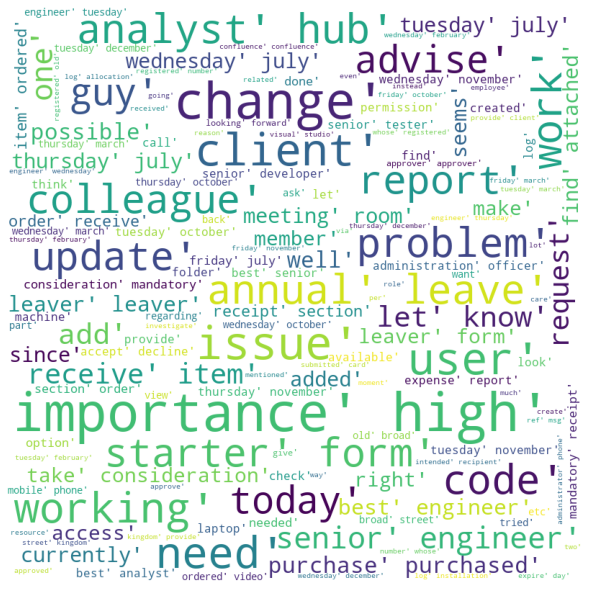

In [34]:
#Final word cloud after all the cleaning and pre-processing
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Topic modelling Visual

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_title, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.092389  0.044048       1        1  38.515263
4     -0.151137 -0.095152       2        1  24.556303
3     -0.114441 -0.182760       3        1  16.088102
0     -0.019363  0.301167       4        1  12.217796
1      0.377330 -0.067303       5        1   8.622530, topic_info=               Term         Freq         Total Category  logprob  loglift
474            form  5535.000000   5535.000000  Default  30.0000  30.0000
386         officer  5409.000000   5409.000000  Default  29.0000  29.0000
1063         access  8942.000000   8942.000000  Default  28.0000  28.0000
117           error  9639.000000   9639.000000  Default  27.0000  27.0000
103   administrator  3503.000000   3503.000000  Default  26.0000  26.0000
...             ...          ...           ...      ...      ...      ...
352          mobile   966.537354   2550.987793   Topic5  -4.7605   1.4803
252            take   914.089905   2529.077393   Topic5  -4.8163   1.4331
85             want   834.591248   2296.835693   Topic5  -4.9073   1.4384
579        thursday   925.888000  10319.271484   Topic5  -4.8035   0.0398
119          friday   867.228027   9771.890625   Topic5  -4.8689   0.0288

[339 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9140      1  0.003103     able
9140      2  0.792766     able
9140      3  0.204009     able
156       2  0.999411  absence
1063      2  0.916744   access
...     ...       ...      ...
299       5  0.001211  working
938       1  0.998337    write
938       4  0.001068    write
212       1  0.984967     zone
212       3  0.014180     zone

[593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

# Topic Modelling on message contents

In [15]:
#import os

In [43]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('thanks')
en_stop.add('please')
en_stop.add('hello')
en_stop.add('regards')
en_stop.add('regard')
en_stop.add('dear')
en_stop.add('thank')
en_stop.add('help')
en_stop.add('kind')
en_stop.add('name')
en_stop.add('also')
en_stop.add('sent')
en_stop.add('ext')
en_stop.add('could')
en_stop.add('date')
en_stop.add('monday')
en_stop.add('tuesday')
en_stop.add('wednesday')
en_stop.add('thursday')
en_stop.add('friday')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
text_data = []

for line in emails_df['body']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [50]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [51]:
NUM_TOPICS = 5
ldamodel_body = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

# Top 10 topics with 5 words in each topic

In [47]:
topics_body = ldamodel_body.print_topics(num_words=5)
for topic in topics_body:
    print(topic)

(0, '0.038*"phone" + 0.024*"administrator" + 0.023*"item" + 0.022*"log" + 0.022*"leaver"')
(1, '0.017*"site" + 0.015*"engineer" + 0.013*"file" + 0.012*"best" + 0.012*"senior"')
(2, '0.039*"report" + 0.015*"update" + 0.015*"action" + 0.014*"number" + 0.013*"information"')
(3, '0.023*"form" + 0.022*"code" + 0.020*"attached" + 0.019*"update" + 0.018*"officer"')
(4, '0.029*"issue" + 0.021*"error" + 0.020*"access" + 0.015*"manager" + 0.012*"problem"')


In [52]:
topics_body = ldamodel_body.print_topics(num_words=5)
for topic in topics_body:
    print(topic)

(0, '0.036*"phone" + 0.029*"administrator" + 0.026*"mailbox" + 0.024*"disk" + 0.024*"item"')
(1, '0.056*"access" + 0.018*"site" + 0.013*"add" + 0.013*"link" + 0.012*"meeting"')
(2, '0.038*"message" + 0.033*"leave" + 0.020*"action" + 0.018*"annual" + 0.014*"day"')
(3, '0.019*"change" + 0.017*"report" + 0.016*"high" + 0.015*"know" + 0.013*"attached"')
(4, '0.035*"issue" + 0.026*"error" + 0.017*"manager" + 0.015*"problem" + 0.013*"card"')


# Topic Modelling Visual

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_body, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.120738  0.112239       1        1  30.828241
1      0.078043 -0.098326       2        1  25.968821
2      0.083432  0.206717       3        1  17.063683
3      0.092518 -0.226436       4        1  15.136911
0     -0.374731  0.005805       5        1  11.002350, topic_info=          Term          Freq         Total Category  logprob  loglift
153     report   8422.000000   8422.000000  Default  30.0000  30.0000
541      phone   5233.000000   5233.000000  Default  29.0000  29.0000
59       issue  11876.000000  11876.000000  Default  28.0000  28.0000
117      error   8726.000000   8726.000000  Default  27.0000  27.0000
523       site   5605.000000   5605.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
459   location    942.622314   3523.871338   Topic5  -4.9903   0.8884
290     ticket   1007.787476   5252.851074   Topic5  -4.9234   0.5560
363    message    825.652100   4354.341309   Topic5  -5.1228   0.5443
0       detail    837.290955   5830.952148   Topic5  -5.1088   0.2663
1006    center    765.602661   1518.106079   Topic5  -5.1983   1.5225

[320 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
9140      1  0.999690        able
1059      1  0.922064      access
1059      2  0.077580      access
1059      3  0.000237      access
451       2  0.998820  accessible
...     ...       ...         ...
295       4  0.018352     working
295       5  0.006292     working
9175      1  0.999219       would
934       2  0.999372       write
209       4  0.999382        zone

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

# Word cloud on the entire dataset

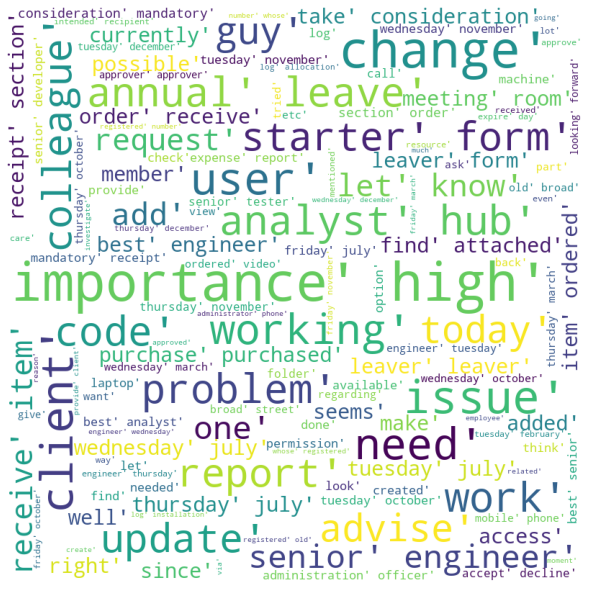

In [22]:
#Final word cloud after all the cleaning and pre-processing
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Word cloud on top 50 words(frquency count)

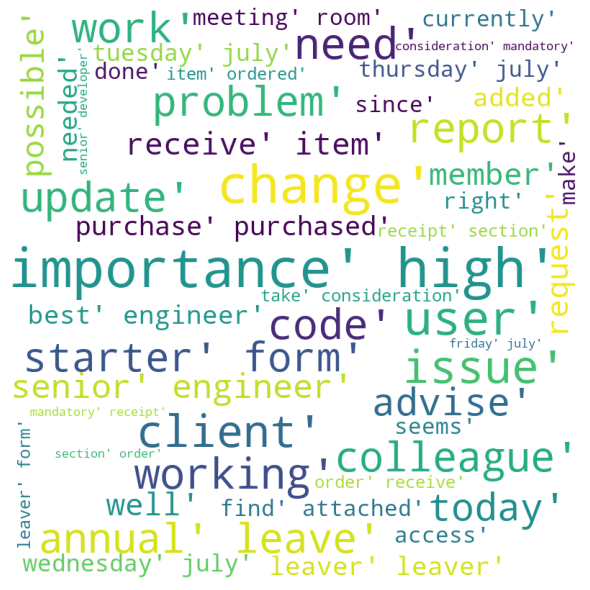

In [23]:
#Final word cloud after all the cleaning and pre-processing
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10, max_words= 50,min_word_length=5).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Word cloud on top 25 words(frquency count)

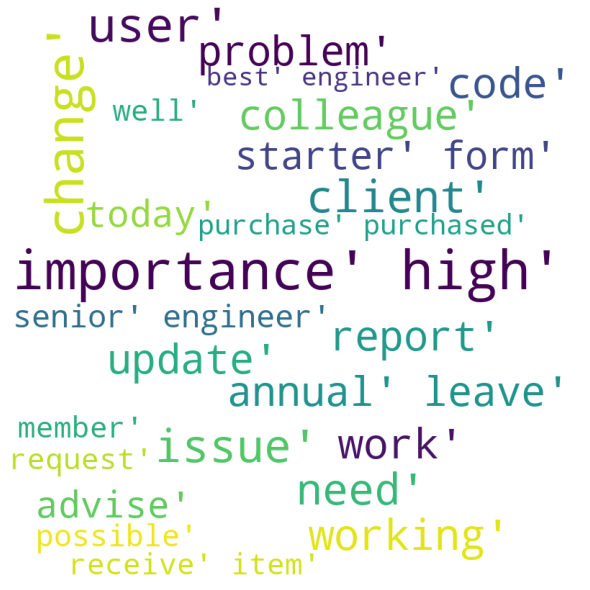

In [24]:
#Final word cloud after all the cleaning and pre-processing
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10, max_words= 25,min_word_length=5).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Top 10 words count graph

In [25]:
filtered_words = [word for word in str(text_data).split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

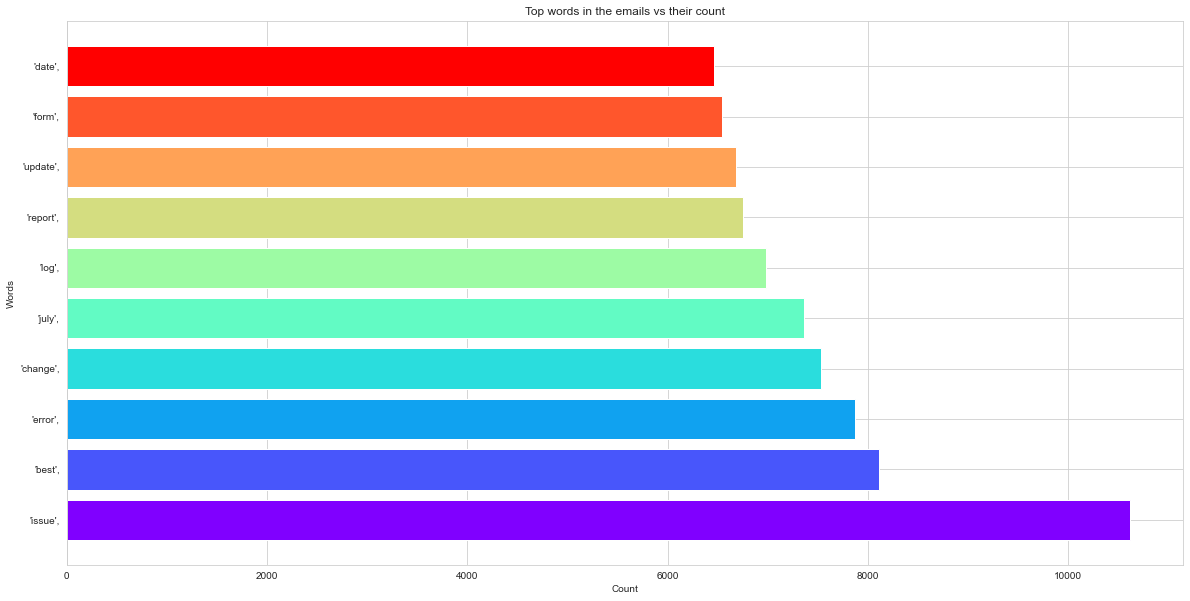

In [26]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the emails vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)